In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
# import torch, torchvision
# from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def get_traingroups(curr, stage):
    if curr=='dev':
        return 'g0g1g2'[:2*stage]
    elif curr=='adev':
        return 'g2g1g0'[:2*stage]
    
def parse_fname(fp):
# embeddings_adev_1_g2_default_0_246.csv'
    parts = Path(fp).stem.split('_')
    prefix, curr, stage, current_gr, cond, fold, seed = parts
    stage=int(stage)
    train_gr = get_traingroups(curr, stage)
    
    tag_dict = {
        'Curriculum':curr,
        'Stage': stage,
        'Condition':cond,
        'Seed': seed,
        'Train Groups': train_gr,
        'data_id': '_'.join([curr, seed, cond])
    }
    return tag_dict

def proc_fp_result(fp):
    df = pd.read_csv(fp)
    tag_dict = parse_fname(fp)
    for tag in tag_dict.keys():
        df[tag] = tag_dict[tag]
    df = df.rename(columns={
    'epoch': 'Epoch',
    'itr': 'Iteration',
    'loss': 'Train Loss'
    })
    df['Train Loss Reduction'] = df['Train Loss'].diff(periods=-1)
#     df['Validation Loss Reduction'] = df['Validation Loss'].diff(periods=-1)
    return df

In [6]:
emb_root = '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/'
# predictive/v1/jul315/'

fpathlist = sorted([emb_root+fname
                for fname in os.listdir(emb_root)
                if Path(emb_root+fname).suffix=='.csv'])
fpathlist

['/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedSpatial_0_315.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedSpatial_0_316.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedSpatial_0_317.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedSpatioTemporal_0_315.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedSpatioTemporal_0_316.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedSpatioTemporal_0_317.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedTemporal_0_315.csv',
 '/N/project/baby_vision_curriculum/trained_models/generative/v3/jul315/csvlog_adev_1_g2_MatchedTemporal_0_316.csv',
 '/N/project/baby_vision_curriculum/trained_model

In [6]:
df_list = []
for fp in fpathlist:
    df_list.append(
        deepcopy(
            proc_fp_result(fp)))
# df_all = pd.concat(df_list)

In [7]:
light_blue = (0.31, 0.62, 0.80)
dark_blue = (0.11, 0.38, 0.65)
light_orange = (0.96, 0.61, 0.31)
dark_orange = (0.87, 0.49, 0.00)

colors = [dark_orange, light_orange, dark_blue, light_blue]

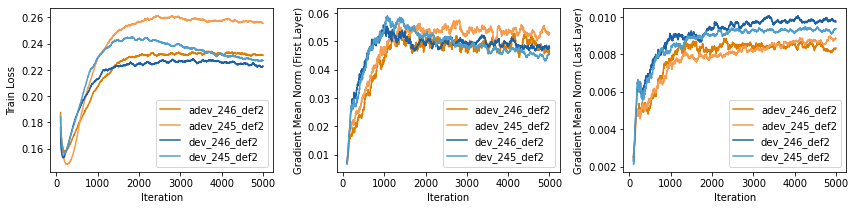

In [9]:
sel_dfs = df_list#[4:6]+df_list[0:2]#df_list[2:6]#
window = 100

fig,ax = plt.subplots(1,3, figsize=(12,3))
# fig,ax = plt.subplots(1,1, figsize=(4,3))
for i_df, df in enumerate(sel_dfs):
    cax=ax[0]
    df['Smooth Train Loss'] = df['Train Loss'].rolling(window=window).mean()
    cax.plot(df['Iteration'], df['Smooth Train Loss'], label=df['data_id'].iloc[0],
           alpha=1, color=colors[i_df])
    
    cax=ax[1]
    df['smooth grad-FL'] = df['grad-FL'].rolling(window=window).mean()
    cax.plot(df['Iteration'], df['smooth grad-FL'], label=df['data_id'].iloc[0],
           alpha=1, color=colors[i_df])
    
#     std = (df['Train Loss'].iloc[200:1000]-df['Smooth Train Loss'].iloc[200:1000]).std()
#     print(df['data_id'].iloc[0], 'std:',std)
    cax=ax[2]
    df['smooth grad-LL'] = df['grad-LL'].rolling(window=window).mean()
    cax.plot(df['Iteration'], df['smooth grad-LL'], label=df['data_id'].iloc[0],
           alpha=1, color=colors[i_df])

# ax.legend()
# ax.set_xlabel('Iteration')
# ax.set_ylabel('Train Loss')

for i_ax in range(3):
    ax[i_ax].legend()
    ax[i_ax].set_xlabel('Iteration')

ax[0].set_ylabel('Train Loss')
ax[1].set_ylabel('Gradient Mean Norm (First Layer)')
ax[2].set_ylabel('Gradient Mean Norm (Last Layer)')
fig.tight_layout()